# Oleveler example for transcriptomics data analysis

### General module import

In [1]:
%load_ext autoreload
%autoreload 2
try:
    from oleveler import *
except:
    from shutil import copy
    copy('../oleveler.py', 'oleveler.py')
    from oleveler import *

# # For interactive plots (PCA, PLS, Loading, volcano), the plots will not be saved if you export this notebook.
# %matplotlib widget

# # For exproting this notebook with plots to HTML
%matplotlib inline

# # You can change plotting style to dark or white using these functions
# setDarkModePlotting(forceDark=True)
# setDarkModePlotting(forceWhite=True)

# # Logging level: INFO = more text shown; WARNING = less text. All INFO level message are anyway stored in the dataProcessing.log file.
logshandler.setLevel(logging.INFO)
# logshandler.setLevel(logging.WARNING)

2021-11-17 15:32:27,627 [INFO] - 
Oleveler - omics data analysis tools for jupyter notebook

Version 1.0
---
by Chao DU
Institute of Biology Leiden, Leiden University, the Netherlands
c.du@biology.leidenuniv.nl
durand[dot]dc[at]hot[no space]mail.com
---




## Data processing

Note the file/folder path is the parameters of the function, please change accroding to your file/folder name.

In [2]:
# Load data
selfAlignCt = gatherCountTable("featureCounts/")
saDf = calculateTPM(selfAlignCt, 'featureCounts/GCF_000203835.1_ASM20383v1_genomic.gff', 
                    tagsForGeneName='locus_tag', removerRNA=True, removeIDcontains=['SCP'])

# Load meta
metaDf, conditions, experiments = loadMeta('Annotation.csv')

# Calculate mean and var
meanDf, nquantDf, varDf, stdDf, semDf = getStats(saDf, experiments)

# Transformation vst using DESeq2
# https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#data-transformations-and-visualization
vstDf = deseq2Process(selfAlignCt, metaDf, ref='WT_45')
# Calculate mean and var
# These data should only be used in plotting, principal analysis, or other stastistical analyses.
vstMeanDf, vstNquantDf, vstVarDf, vstStdDf, vstSemDf = getStats(vstDf, experiments, title='vst')

2021-11-17 15:32:27,652 [INFO] - Raw count table gathered from featureCounts/
2021-11-17 15:32:27,856 [INFO] - TPM data read from dataTables/TPM_Table_6a7aec.tsv.
2021-11-17 15:32:27,856 [INFO] - ####### Load metadata #######
2021-11-17 15:32:27,857 [INFO] - Metadata path: Annotation.csv
2021-11-17 15:32:27,862 [INFO] - ####### END Load metadata #######

2021-11-17 15:32:27,919 [INFO] - Read basic stats from dataTables/mean_417110.tsv
2021-11-17 15:32:27,920 [INFO] - Read basic stats from dataTables/nquant_417110.tsv
2021-11-17 15:32:27,921 [INFO] - Read basic stats from dataTables/var_417110.tsv
2021-11-17 15:32:27,922 [INFO] - Read basic stats from dataTables/std_417110.tsv
2021-11-17 15:32:27,923 [INFO] - Read basic stats from dataTables/sem_417110.tsv
2021-11-17 15:32:27,934 [INFO] - Current deseq2Process parameter hash = 2f3e41
2021-11-17 15:32:27,936 [INFO] - Read VST transformed data from dataTables/transformed/vst_2f3e41.tsv.
2021-11-17 15:32:28,009 [INFO] - Read basic stats fr

### DESeq2 different expression analysis

In [3]:
# Differential expression analysis
# https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#differential-expression-analysis
deseq2CompResults, comparisons = makeCompMatrixDeseq2('comparisons.xlsx', 
                                                      selfAlignCt,
                                                      'annotation.csv',
                                                      shrink=None)

2021-11-17 15:32:28,116 [INFO] - Current comparisons.xlsx hash = 22d17e42a0b9d9f0bf51b7178f8e86f6.
2021-11-17 15:32:28,117 [INFO] - Current input table hash = 922b2a8e90b737f186b9a615e2c8d526.
2021-11-17 15:32:28,117 [INFO] - They should match previous result dataTables/transformed/deseq2_comparisonResult_22d17e_922b2a.tsv.


In [4]:
# Differential expression analysis with log fold change shrinkage for visualization and ranking
# https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#log-fold-change-shrinkage-for-visualization-and-ranking
deseq2CompResultsShrink, comparisons = makeCompMatrixDeseq2('comparisons.xlsx', 
                                                            selfAlignCt,
                                                            'annotation.csv',
                                                            shrink='lfcShrink')

2021-11-17 15:32:28,191 [INFO] - Current comparisons.xlsx hash = 22d17e42a0b9d9f0bf51b7178f8e86f6.
2021-11-17 15:32:28,192 [INFO] - Current input table hash = 922b2a8e90b737f186b9a615e2c8d526.
2021-11-17 15:32:28,193 [INFO] - They should match previous result dataTables/transformed/deseq2_comparisonResult_lfcShrink_22d17e_922b2a.tsv.


## General analysis

### Principal components analysis (PCA)

Unsupervised data reduction.

2021-11-17 15:32:28,261 [INFO] - Plotting PCA plot - VST df (no gbn)_a42800
2021-11-17 15:32:28,343 [INFO] - Save PCA plot at Plots/PCA/PCA_VST df (no gbn)_C24_1_C24_2..._a42800.svg
2021-11-17 15:32:28,411 [INFO] - Save PCA data at Plots/PCA/PCA_VST df (no gbn)_C24_1_C24_2..._a42800.xlsx


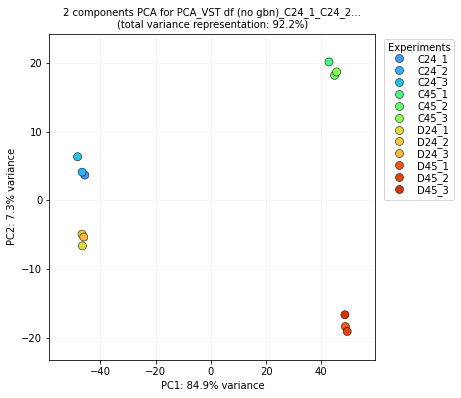

2021-11-17 15:32:28,512 [INFO] - Plotting PCA_explaination_91c00b
2021-11-17 15:32:28,530 [INFO] - Save PCA explanation plot at Plots/PCA/PCA_explaination_91c00b.svg
2021-11-17 15:32:28,566 [INFO] - Save PCA explanation data at Plots/PCA/PCA_explaination_91c00b.xlsx


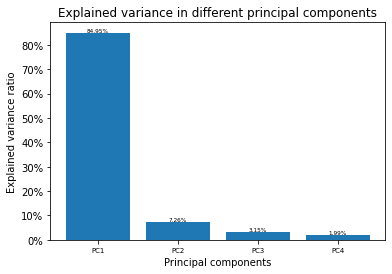

2021-11-17 15:32:28,639 [INFO] - Plotting PCA_loading_VST df (no gbn)_0f7c9b
2021-11-17 15:32:29,151 [INFO] - Save PCA loading plot at Plots/PCA/PCA_loading_VST df (no gbn)C24_1_C24_2..._0f7c9b.svg
2021-11-17 15:32:30,060 [INFO] - Save PCA loading plot data at Plots/PCA/PCA_loading_VST df (no gbn)C24_1_C24_2..._0f7c9b.xlsx


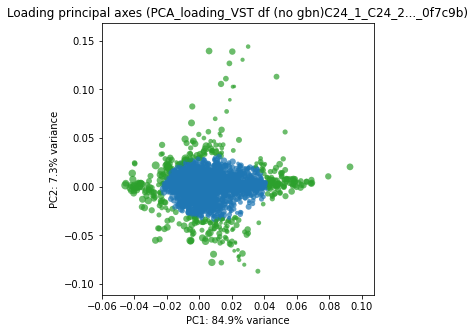

In [5]:
# I have a gene knockout in the mutant, so it is slightly better if I remove data of this gene before analysis
newVstDf = vstDf[vstDf.index != 'SCO1839']

# Do a PCA plot
PcaClass_vst = plotPrincipleAnalysis(newVstDf, colourSet=genColour(vstDf.columns), figsize=(7,6),
                                     title='VST df (no gbn)', analysisType='PCA')
# Get some info about the PCA result just generated
plotPCAExplanation(PcaClass_vst)

# Loading plot of the same PCA. Note the loading plot function do not dependent on the PCA result before.
plotPrincipleAnalysisLoading(newVstDf, drawOutliers=True, outlierAlg=0, outliersFraction=0.05, title='VST df (no gbn)')

You can also customise data for any analysis on the fly. eg. Use only part of the data by constraining the columns of the data table.

2021-11-17 15:32:30,722 [INFO] - Plotting PCA plot - VST 24h only_20139d
2021-11-17 15:32:30,774 [INFO] - Save PCA plot at Plots/PCA/PCA_VST 24h only_C24_1_C24_2..._20139d.svg
2021-11-17 15:32:30,851 [INFO] - Save PCA data at Plots/PCA/PCA_VST 24h only_C24_1_C24_2..._20139d.xlsx


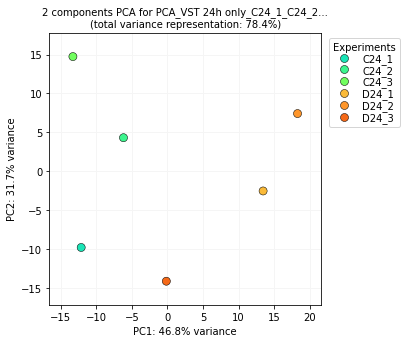

PCA()

In [6]:
cols = [
    'C24_1', 'C24_2', 'C24_3', 
#     'C45_1', 'C45_2', 'C45_3', 
    'D24_1', 'D24_2', 'D24_3', 
#     'D45_1', 'D45_2', 'D45_3',
]
plotPrincipleAnalysis(newVstDf, cols=cols, title='VST 24h only', colourSet=genColour(cols))

### Partial least squares regression (PLS regression)

Supervised data reduction.

2021-11-17 15:32:30,965 [INFO] - Plotting PLS plot - VST df_4bbc63
2021-11-17 15:32:31,070 [INFO] - PLS: Coefficient of determination R^2: 0.9502180854823554
2021-11-17 15:32:31,100 [INFO] - Save PCA plot at Plots/PLS/PLS_VST df_C24_1_C24_2..._4bbc63.svg
2021-11-17 15:32:31,257 [INFO] - Save PCA data at Plots/PLS/PLS_VST df_C24_1_C24_2..._4bbc63.xlsx


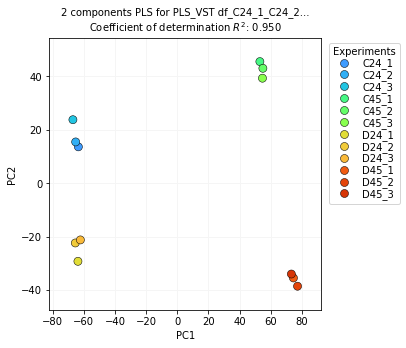

2021-11-17 15:32:31,372 [INFO] - Plotting PLS_Vplot_VST_fd837e
2021-11-17 15:32:31,475 [INFO] - PLS: Coefficient of determination R^2: 0.9501573337170055


/home/duc/micromamba/envs/oleveler/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


2021-11-17 15:32:32,061 [INFO] - Save V plot at Plots/PLS/PLS_Vplot_VST_C24_1_C24_2..._fd837e.svg
2021-11-17 15:32:32,948 [INFO] - Save V plot data at Plots/PLS/PLS_Vplot_VST_C24_1_C24_2..._fd837e.xlsx


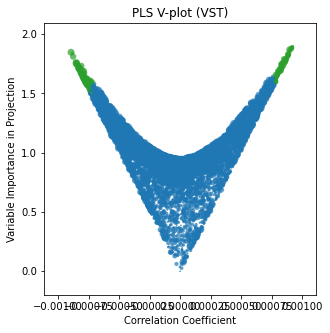

In [7]:
# First make a class table based on your data. Describe your conditions in numbers.
# In this example, the first column (0 and 2) indicates wild type and mutant (strains),
# the second column (24 and 45) indicates time after inoculation. You can use numbers with
# larger difference to give specific element higher impact.
plsClasses = [
              [0,24],
              [0,24],
              [0,24],
              [0,45],
              [0,45],
              [0,45],
              [2,24],
              [2,24],
              [2,24],
              [2,45],
              [2,45],
              [2,45],
]

# Do PLS and plot. analysisType='PLS'
PlsClass_vst = plotPrincipleAnalysis(vstDf,
                                     colourSet=genColour(vstDf.columns),
                                     title='VST df', analysisType='PLS', plsClasses=plsClasses)

# V plot of PLS showing the importance of each genes contributing to the seperation.
plotPlsVplot(newVstDf, classes=plsClasses, title='VST', outlierAlg=1)

PLS for part of the data is also doable.

2021-11-17 15:32:33,601 [INFO] - Plotting PLS plot - VST 24h only_875e5c
2021-11-17 15:32:33,707 [INFO] - PLS: Coefficient of determination R^2: 0.9996601359093062
2021-11-17 15:32:33,738 [INFO] - Save PCA plot at Plots/PLS/PLS_VST 24h only_C24_1_C24_2..._875e5c.svg
2021-11-17 15:32:33,789 [INFO] - Save PCA data at Plots/PLS/PLS_VST 24h only_C24_1_C24_2..._875e5c.xlsx


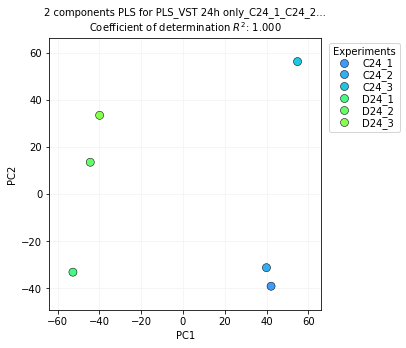

In [8]:
# Simply comment out the non-required data from both classes info and columns of data frame.
plsClasses = [
              [0,24],
              [0,24],
              [0,24],
#               [0,45],
#               [0,45],
#               [0,45],
              [2,24],
              [2,24],
              [2,24],
#               [2,45],
#               [2,45],
#               [2,45],
]
cols = [
    'C24_1', 'C24_2', 'C24_3', 
#     'C45_1', 'C45_2', 'C45_3', 
    'D24_1', 'D24_2', 'D24_3', 
#     'D45_1', 'D45_2', 'D45_3',
]
PlsClass_vst = plotPrincipleAnalysis(newVstDf,cols=cols, colourSet=genColour(vstDf.columns),
                                     title='VST 24h only', analysisType='PLS', plsClasses=plsClasses)

### Correlation plot

2021-11-17 15:32:33,978 [INFO] - Save correlation plot at Plots/Correlation/Correlation_C24_1_C24_2b228b3.svg
2021-11-17 15:32:34,042 [INFO] - Save correlation data at Plots/Correlation/Correlation_C24_1_C24_2b228b3.xlsx


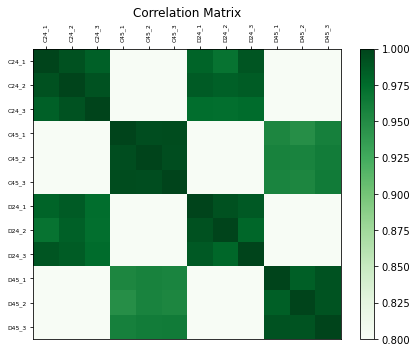

In [9]:
plotCorr(vstDf, cols=[c for c in vstDf if c!='QC'], vmin=0.8)

### Volcano plot for each comparison

In [10]:
# First let us see how many comparison pairs are stored in the comparison results
comparisons

{'mu_wt24': {'exp': 'Dgbn_24', 'ctr': 'WT_24'},
 'mu_wt45': {'exp': 'Dgbn_45', 'ctr': 'WT_45'},
 'wt45_24': {'exp': 'WT_45', 'ctr': 'WT_24'},
 'mu45_24': {'exp': 'Dgbn_45', 'ctr': 'Dgbn_24'}}

It is possible to highlight selected genes in the volcano plot.

2021-11-17 15:32:34,197 [INFO] - Plotting Volcano_DESeq2_shrink_comp_result_mu_wt24_913ef4
2021-11-17 15:32:34,301 [INFO] - Save volcano figure at Plots/Volcano/Volcano_DESeq2_shrink_comp_result_mu_wt24_913ef4.svg
2021-11-17 15:32:35,390 [INFO] - Save volcano original data at Plots/Volcano/Volcano_DESeq2_shrink_comp_result_mu_wt24_913ef4.xlsx
2021-11-17 15:32:35,391 [INFO] - Save volcano plot data at Plots/Volcano/Volcano_DESeq2_shrink_comp_result_mu_wt24_913ef4_filled.xlsx


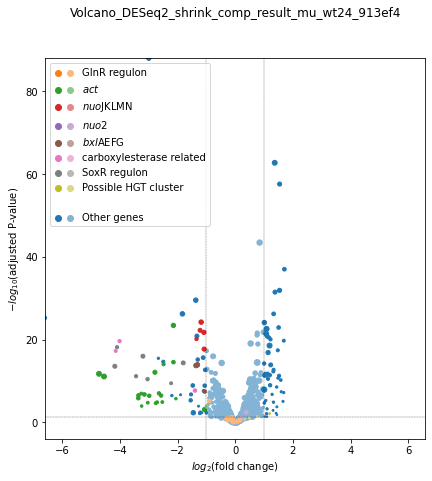

In [11]:
# for c in comparisons:
for c in ['mu_wt24']:
    cols = metaDf[(metaDf.Condition==comparisons[c]['exp']) | \
                  (metaDf.Condition==comparisons[c]['ctr'])].Experiment.values
    plotVolcano(deseq2CompResultsShrink[c],
                # Second argument is data used for the size of each point on the plot. This is optional.
                # If not provided, it will try to use the "mean" column from comparison result.
                vstDf[cols].mean(axis=1), 
                xmax = 6, ymax=80,
                # Highlight is achieved by passing an OrderedDict (or Dict), list of lists to this highlights parameter
                highlights=OrderedDict([
                    ('GlnR regulon' , ['SCO2198', # glnA
                            'SCO5583', 'SCO5584', 'SCO5585', # amtB, glnK, glnD
                            'SCO2210', # glnII
                            'SCO4683', # gdhA
                            'SCO2486','SCO2487', 'SCO2488', # nirB_a, nirB_b, nirCD
                            'SCO1236', 'SCO1235', 'SCO1234', 'SCO1233',# ureA, B, C, F
                            'SCO0255', 'SCO0888', 'SCO2400', 'SCO2404', 'SCO1863', 'SCO2195', 'SCO7155'
                           ]),
                    (r'$act$',[f'SCO{i}' for i in range(5071, 5093)]), # Latex syntex is supported in the name
                    (r'$nuo$JKLMN', [f'SCO{i}' for i in range(4571, 4576)]),
                    (r'$nuo2$'  ,[f'SCO{i}' for i in range(4599, 4609)]),
                    (r"$bxl$AEFG", [f'SCO{i}' for i in range(7028,7032)]),
                    ("carboxylesterase related", [f'SCO0{i}' for i in range(319,322)]),
                    ("SoxR regulon", ['SCO4265', 'SCO4266','SCO2477','SCO2478', 'SCO7008', 'SCO1909', 'SCO1178']),
                    ('Possible HGT cluster',[f'SCO{i}' for i in range(4615, 4628)]),
                ]),
                figsize=(7,7),
                title=f'shrink_comp_result_{c}')

2021-11-17 15:32:36,897 [INFO] - Plotting Volcano_DESeq2_shrink_comp_result_mu_wt45_ba9ac0
2021-11-17 15:32:36,999 [INFO] - Save volcano figure at Plots/Volcano/Volcano_DESeq2_shrink_comp_result_mu_wt45_ba9ac0.svg
2021-11-17 15:32:38,160 [INFO] - Save volcano original data at Plots/Volcano/Volcano_DESeq2_shrink_comp_result_mu_wt45_ba9ac0.xlsx
2021-11-17 15:32:38,161 [INFO] - Save volcano plot data at Plots/Volcano/Volcano_DESeq2_shrink_comp_result_mu_wt45_ba9ac0_filled.xlsx


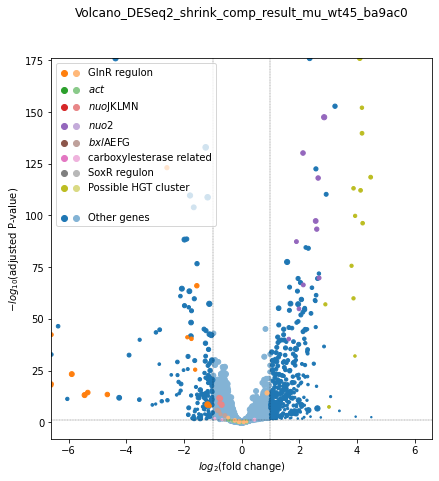

In [12]:
for c in ['mu_wt45']:
    cols = metaDf[(metaDf.Condition==comparisons[c]['exp']) | \
                  (metaDf.Condition==comparisons[c]['ctr'])].Experiment.values
    plotVolcano(deseq2CompResultsShrink[c], 
                vstDf[cols].mean(axis=1), 
                highlights=OrderedDict([
                    ('GlnR regulon' , ['SCO2198', # glnA
                            'SCO5583', 'SCO5584', 'SCO5585', # amtB, glnK, glnD
                            'SCO2210', # glnII
                            'SCO4683', # gdhA
                            'SCO2486','SCO2487', 'SCO2488', # nirB_a, nirB_b, nirCD
                            'SCO1236', 'SCO1235', 'SCO1234', 'SCO1233',# ureA, B, C, F
                            'SCO0255', 'SCO0888', 'SCO2400', 'SCO2404', 'SCO1863', 'SCO2195', 'SCO7155'
                           ]),
                    (r'$act$',[f'SCO{i}' for i in range(5071, 5093)]),
                    (r'$nuo$JKLMN', [f'SCO{i}' for i in range(4571, 4576)]),
                    (r'$nuo2$'  ,[f'SCO{i}' for i in range(4599, 4609)]),
                    (r"$bxl$AEFG", [f'SCO{i}' for i in range(7028,7032)]),
                    ("carboxylesterase related", [f'SCO0{i}' for i in range(319,322)]),
                    ("SoxR regulon", ['SCO4265', 'SCO4266','SCO2477','SCO2478', 'SCO7008', 'SCO1909', 'SCO1178']),
                    ('Possible HGT cluster',[f'SCO{i}' for i in range(4615, 4628)]),
#                     ('Nit' ,[f'SCO{i}' for i in range(5583, 5586)]),
#                     ('Nir' ,[f'SCO{i}' for i in range(2486, 2489)]),
#                     ('pGlnr' , ['SCO2471', 'SCO2472', 'SCO2473']),
#                     ('Act',[f'SCO{i}' for i in range(5071, 5093)]),
#                     ('red',[f'SCO{i}' for i in range(5877, 5899)]),
#                     ('cpk',[f'SCO{i}' for i in range(6273, 6289)]),
#                     ('whi',[f'SCO{i}' for i in [3034,4543,4767,5621,6029,1950,5314,5315,5316,5317,5318,5319,5320,5321,5819]]),
#                     ('bld',[f'SCO{i}' for i in [1489,3323,3549,4091,4768,5112,5113,5114,5115,5116,5723,2792]])
                ]),
                figsize=(7,7),
                xmax = 6, ymax=160,
                title=f'shrink_comp_result_{c}')

### Expression profile clustering (co-expression analysis)

Heat map and expression profile of each cluster.

/home/duc/micromamba/envs/oleveler/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


2021-11-17 15:32:40,295 [INFO] - Save cluster plot at Plots/Clustermap/Heatmap_sig_mu_wt45_6f7c85.svg


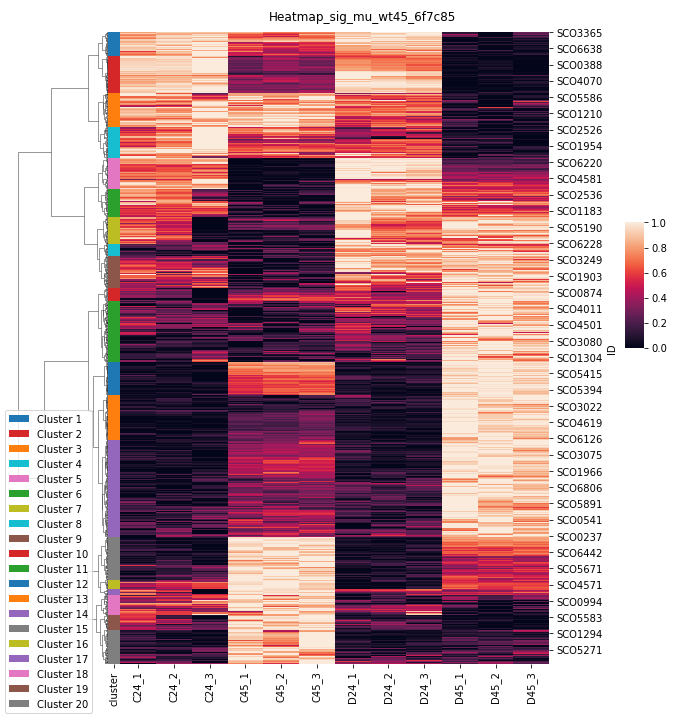

In [13]:
# First get the desired data set: for this project,
# I select to cluster the genes that significantly changed
# in the comparison between mutant and wild type at 45 hours.
sigDf = getSig(deseq2CompResultsShrink['mu_wt45'], tPv=0.01)

# use all data
cols = ['C24_1', 'C24_2', 'C24_3', 'C45_1', 'C45_2', 'C45_3',
        'D24_1', 'D24_2', 'D24_3', 'D45_1', 'D45_2', 'D45_3']

cluster, fname = plotHeatmapGetCluster(vstDf, sigDf.index, cols,
                                       nCluster=20,
                                       saveFig=True,
                                       ylabels="AUTO",
                                       standard_scale='row',
                                       plot=True, title='sig_mu_wt45')

2021-11-17 15:32:43,252 [INFO] - Save cluster expression plot at Plots/Clustermap/Heatmap_sig_mu_wt45_6f7c85_cluster_all_dfa076.svg
2021-11-17 15:32:44,902 [INFO] - Save cluster ids table at Plots/Clustermap/Heatmap_sig_mu_wt45_6f7c85_cluster_all_dfa076.xlsx


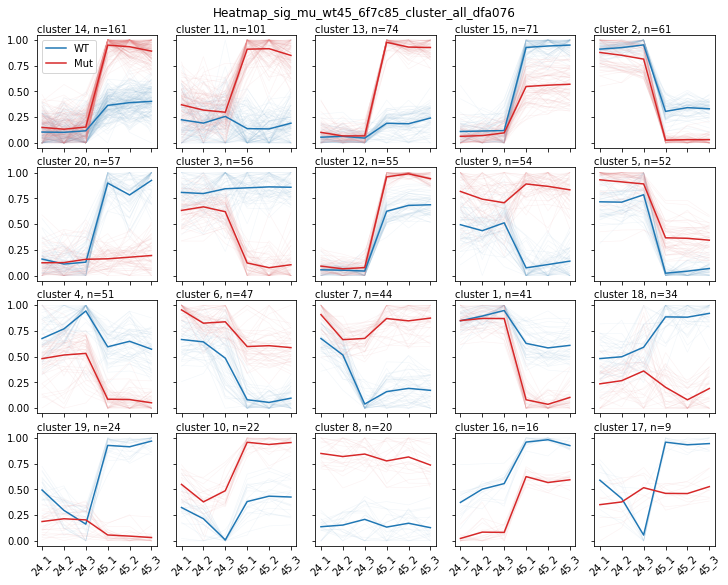

In [14]:
plotCluster(cluster, fname,
            saveFig=True,
            conditions = [['C24_1', 'C24_2', 'C24_3', 'C45_1', 'C45_2', 'C45_3'],
                          ['D24_1', 'D24_2', 'D24_3', 'D45_1', 'D45_2', 'D45_3']],
            dataLabels = ['WT', 'Mut'],
            xlabels = ['24_1', '24_2', '24_3', '45_1', '45_2', '45_3'],
            longWide='long',
            xlabelRotation=45)

You can also choose to plot only interesting clusters:

2021-11-17 15:32:47,388 [INFO] - Save cluster expression plot at Plots/Clustermap/Heatmap_sig_mu_wt45_6f7c85_cluster_1_11_14_18_19_ef5273.svg
2021-11-17 15:32:47,897 [INFO] - Save cluster ids table at Plots/Clustermap/Heatmap_sig_mu_wt45_6f7c85_cluster_1_11_14_18_19_ef5273.xlsx


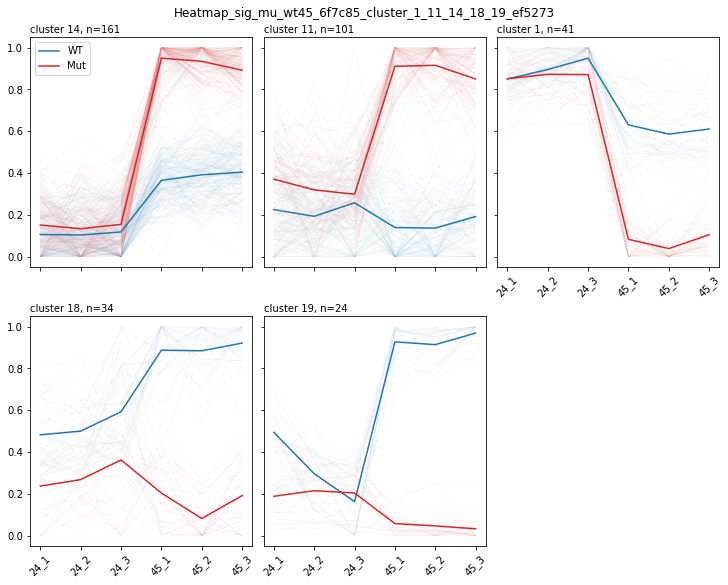

In [15]:
plotCluster(cluster, fname,
            saveFig=True,
            clusters=[1,14,11,18,19],
            conditions = [['C24_1', 'C24_2', 'C24_3', 'C45_1', 'C45_2', 'C45_3'],
                          ['D24_1', 'D24_2', 'D24_3', 'D45_1', 'D45_2', 'D45_3']],
            dataLabels = ['WT', 'Mut'],
            xlabels = ['24_1', '24_2', '24_3', '45_1', '45_2', '45_3'],
            longWide='long',
            xlabelRotation=45)

## Query genes

### Many genes and many conditions

2021-11-17 15:32:48,611 [INFO] - Query with name: query_bar_SCO1839_SCO4117_64fe9f
2021-11-17 15:32:48,663 [INFO] - Save query figure at Plots/query/query_bar_SCO1839_SCO4117_64fe9f.svg
2021-11-17 15:32:48,697 [INFO] - Save query table at Plots/query/query_bar_SCO1839_SCO4117_64fe9f.xlsx


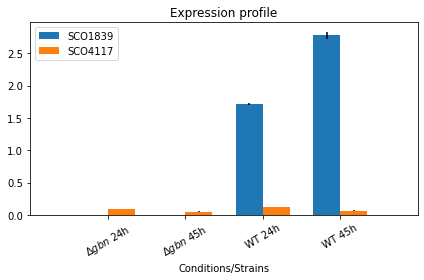

2021-11-17 15:32:48,774 [INFO] - Query with name: query_line fill_SCO1839_SCO4117_b67fb3
2021-11-17 15:32:48,880 [INFO] - Save query figure at Plots/query/query_line fill_SCO1839_SCO4117_b67fb3.svg
2021-11-17 15:32:48,910 [INFO] - Save query table at Plots/query/query_line fill_SCO1839_SCO4117_b67fb3.xlsx


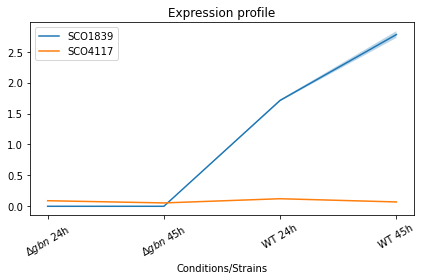

2021-11-17 15:32:48,982 [INFO] - Query with name: query_line bar_SCO1839_SCO4117_d189f8
2021-11-17 15:32:49,027 [INFO] - Save query figure at Plots/query/query_line bar_SCO1839_SCO4117_d189f8.svg
2021-11-17 15:32:49,062 [INFO] - Save query table at Plots/query/query_line bar_SCO1839_SCO4117_d189f8.xlsx


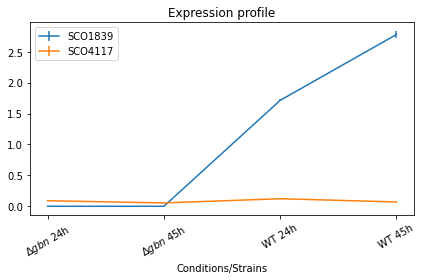

In [16]:
queryGenes = ['SCO1839', 'SCO4117']

queryConditions = ['Dgbn_24', 'Dgbn_45', 'WT_24', 'WT_45'  ]
query(meanDf, semDf, queryGenes, queryConditions, 
      xlabels=[r'${\Delta}gbn$ 24h', r'${\Delta}gbn$ 45h', 
               'WT 24h',            'WT 45h'  ],
      xlabelRotation=30, plotType='bar')
      # xlabelRotation=30, plotType='line fill')
      # xlabelRotation=30, plotType='line bar')

query(meanDf, semDf, queryGenes, queryConditions, 
      xlabels=[r'${\Delta}gbn$ 24h', r'${\Delta}gbn$ 45h', 
               'WT 24h',            'WT 45h'  ],
      # xlabelRotation=30, plotType='bar')
      xlabelRotation=30, plotType='line fill')
      # xlabelRotation=30, plotType='line bar')

query(meanDf, semDf, queryGenes, queryConditions, 
      xlabels=[r'${\Delta}gbn$ 24h', r'${\Delta}gbn$ 45h', 
               'WT 24h',            'WT 45h'  ],
      # xlabelRotation=30, plotType='bar')
      # xlabelRotation=30, plotType='line fill')
      xlabelRotation=30, plotType='line bar')


If you have a series of genes to query

2021-11-17 15:32:49,150 [INFO] - Query with name: query_bar_SCO4265_SCO4266_98dec3
2021-11-17 15:32:49,231 [INFO] - Save query figure at Plots/query/query_bar_SCO4265_SCO4266_98dec3.svg
2021-11-17 15:32:49,278 [INFO] - Save query table at Plots/query/query_bar_SCO4265_SCO4266_98dec3.xlsx


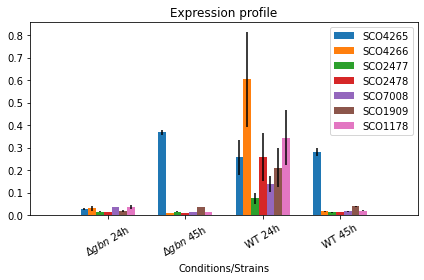

In [17]:
soxRRegulon = ['SCO4265', 'SCO4266','SCO2477','SCO2478', 'SCO7008', 'SCO1909', 'SCO1178']
queryConditions = ['Dgbn_24', 'Dgbn_45',   'WT_24', 'WT_45'  ]
query(meanDf, semDf, soxRRegulon, queryConditions, 
      xlabels=[r'${\Delta}gbn$ 24h', r'${\Delta}gbn$ 45h', 
               'WT 24h',            'WT 45h'  ],
      xlabelRotation=30, plotType='bar')
#       xlabelRotation=30, plotType='line fill')
#       xlabelRotation=30, plotType='line bar')


### Single gene, reduce one factor (eg. combine strains)

2021-11-17 15:32:49,399 [INFO] - Query with name: query_bar_SCO7028_c53b71
2021-11-17 15:32:49,436 [INFO] - Save query figure at Plots/query/query_bar_SCO7028_c53b71.svg
2021-11-17 15:32:49,455 [INFO] - Save query table at Plots/query/query_bar_SCO7028_c53b71.xlsx


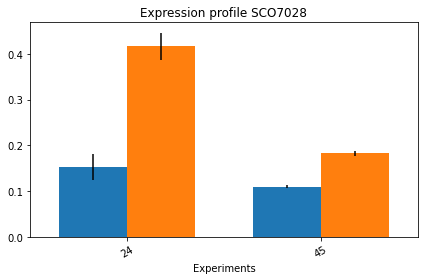

2021-11-17 15:32:49,513 [INFO] - Query with name: query_line fill_SCO7028_5001cf
2021-11-17 15:32:49,551 [INFO] - Save query figure at Plots/query/query_line fill_SCO7028_5001cf.svg
2021-11-17 15:32:49,570 [INFO] - Save query table at Plots/query/query_line fill_SCO7028_5001cf.xlsx


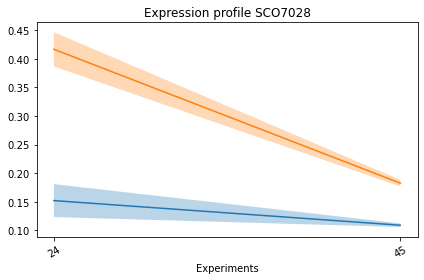

2021-11-17 15:32:49,628 [INFO] - Query with name: query_line bar_SCO7028_39173d
2021-11-17 15:32:49,669 [INFO] - Save query figure at Plots/query/query_line bar_SCO7028_39173d.svg
2021-11-17 15:32:49,689 [INFO] - Save query table at Plots/query/query_line bar_SCO7028_39173d.xlsx


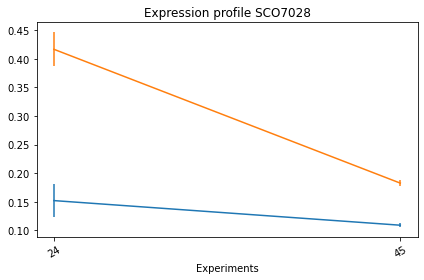

In [18]:
# Crystal structure of the solute-binding protein 
# BxlE from Streptomyces thermoviolaceus OPC-520 complexed with xylobiose
queryGenes = 'SCO7028'

# Put the conditions you want to put together in the same column
queryConditions = [['Dgbn_24','Dgbn_45'],
                   ['WT_24',  'WT_45'  ]]
query(meanDf, semDf, queryGenes,
      queryConditions,
      queryConditionGroupNames=[[r'M145${\Delta}gbn$','M145'],[24,45]],
      xlabelRotation=30,
      plotType='bar')
      # plotType='line fill')
      # plotType='line bar')

query(meanDf, semDf, queryGenes,
      queryConditions,
      queryConditionGroupNames=[[r'M145${\Delta}gbn$','M145'],[24,45]],
      xlabelRotation=30,
      plotType='line fill')
      # plotType='line bar')

query(meanDf, semDf, queryGenes,
      queryConditions,
      queryConditionGroupNames=[[r'M145${\Delta}gbn$','M145'],[24,45]],
      xlabelRotation=30,
      # plotType='line fill')
      plotType='line bar')

It is also possible to use only part of the conditions. eg. the gene SCO1839 has been knocked out in the mutant, so it is not necessary to show its expression.

2021-11-17 15:32:49,765 [INFO] - Query with name: query_bar_SCO1839_8fb56e
2021-11-17 15:32:49,789 [INFO] - Save query figure at Plots/query/query_bar_SCO1839_8fb56e.svg
2021-11-17 15:32:49,813 [INFO] - Save query table at Plots/query/query_bar_SCO1839_8fb56e.xlsx


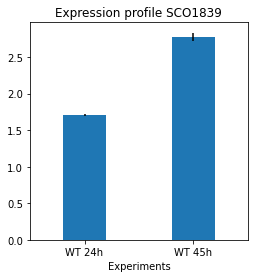

In [19]:
queryConditions = ['WT_24', 'WT_45'  ]
query(meanDf, semDf, 'SCO1839', queryConditions, 
      xlabels=['WT 24h', 'WT 45h'],
      figsize=(4, 4),
      plotType='bar', square=True,
      width=0.2,
     )
#       xlabelRotation=30, plotType='line fill')
#       xlabelRotation=30, plotType='line bar')


---

## Export R session infomation (package versions etc.)

In [20]:
writeRSessionInfo('RSessionInfo.txt', overwrite=False)

2021-11-17 15:32:49,883 [INFO] - No R packages loaded in current session


0